In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
bbg_prices = pd.read_excel("../data/Bloomberg_Prices.xlsx")
bbg_msci_prices = pd.read_excel(
    "../data/Bloomberg_Prices.xlsx", sheet_name="MSCI_World"
)
data_dict = pd.read_excel("../data/Data_dictionary.xlsx")
data_msci = pd.read_csv("../data/DataMSCI.csv", sep=";")

In [12]:
print(bbg_prices.shape)
print(bbg_msci_prices.shape)
print(data_dict.shape)
print(data_msci.shape)

(786, 1395)
(785, 2)
(9382, 10)
(1394, 60)


In [13]:
bbg_prices.head()

,Dates,US1264081035,US1270971039,CA5592224011,US8326964058,US8425871071,US78409V1044,US5732841060,US2371941053,CA05534B7604,...,US83444M1018,CA0084741085,US09290D1019,CH1335392721,US5049221055,IE00028FXN24,US4385161066,US88160R1014,US31488V1070,IE000IVNQZ81
0,2021-11-15,35.19,20.82,88.55,128.92,62.20,459.28,418.63,147.68,51.31,...,NaN,57.37,953.24,NaN,245.1021,NaN,222.47,337.7967,158.03,164.23
1,2021-11-16,35.15,20.98,88.28,127.51,62.00,470.37,421.95,146.62,50.96,...,NaN,56.33,948.95,NaN,247.7309,NaN,221.37,351.5767,159.61,164.90
2,2021-11-17,35.54,20.61,87.85,127.80,62.17,465.50,423.56,147.00,51.03,...,NaN,57.01,931.54,NaN,248.8992,NaN,220.49,363.0033,161.21,166.05
3,2021-11-18,36.21,20.77,87.84,125.85,61.63,463.93,420.25,145.92,51.06,...,NaN,55.79,922.77,NaN,246.9749,NaN,220.70,365.4600,163.60,164.15
4,2021-11-19,36.08,19.99,85.75,124.31,62.67,461.31,417.43,143.16,51.16,...,NaN,54.35,914.95,NaN,243.3926,NaN,218.49,379.0200,161.48,165.25


In [14]:
data_msci.head()

,ISSUER_NAME,ISSUERID,ISSUER_ISIN,ISSUER_LEI,ISSUER_TICKER,CARBON_EMISSIONS_SCOPE_12_FY09,CARBON_EMISSIONS_SCOPE_12_FY10,CARBON_EMISSIONS_SCOPE_12_FY11,CARBON_EMISSIONS_SCOPE_12_FY12,CARBON_EMISSIONS_SCOPE_12_FY13,...,SALES_USD_FY14,SALES_USD_FY15,SALES_USD_FY16,SALES_USD_FY17,SALES_USD_FY18,SALES_USD_FY19,SALES_USD_FY20,SALES_USD_FY21,SALES_USD_FY22,SALES_USD_FY23
0,CSX Corporation,IID000000002123685,US1264081035,549300JVQR4N1MMP3Q88,CSX,5028640.0,5470674.0,5695440.0,5569075.0,5564960.0,...,12669.00,11811.00,11069.00,11408.00,12250.00,11937.00,10583.00,12522.00,14853.00,14657.00
1,Coterra Energy Inc.,IID000000002123686,US1270971039,FCNMH6O7VWU7LHXMK351,CTRA,365053.0,350423.0,1059051.0,1232734.0,576547.0,...,1953.69,1300.46,1194.63,1747.29,2143.72,2066.28,1405.22,3670.00,9514.00,5684.00
2,Magna International Inc.,IID000000002123690,CA5592224011,95RWVLFZX6VGDZNNTN43,MG,645050.0,1317000.0,1222940.0,1509298.0,1637018.0,...,35046.63,32134.00,35909.37,40254.61,38844.54,40234.98,32647.00,35952.21,36406.77,43753.49
3,THE J. M. SMUCKER COMPANY,IID000000002123695,US8326964058,5493000WDH6A0LHDJD55,SJM,402447.0,407538.0,373927.0,357065.0,367913.0,...,5692.70,7811.22,7392.30,7357.10,7838.00,7801.00,8002.70,7998.90,8529.20,8178.70
4,THE SOUTHERN COMPANY,IID000000002123700,US8425871071,549300FC3G3YU2FBZD92,SO,123586162.0,134244544.0,123269872.0,101336846.0,104414567.0,...,18467.00,17489.00,19896.00,23031.00,23495.00,21419.00,20375.00,23113.00,29279.00,25253.00


In [15]:
bbg_prices["Dates"] = pd.to_datetime(bbg_prices["Dates"])
bbg_prices.set_index("Dates", inplace=True)

In [16]:
bbg_prices.head()

,US1264081035,US1270971039,CA5592224011,US8326964058,US8425871071,US78409V1044,US5732841060,US2371941053,CA05534B7604,US8636671013,...,US83444M1018,CA0084741085,US09290D1019,CH1335392721,US5049221055,IE00028FXN24,US4385161066,US88160R1014,US31488V1070,IE000IVNQZ81
Dates,,,,,,,,,,,,,,,,,,,,,
2021-11-15,35.19,20.82,88.55,128.92,62.20,459.28,418.63,147.68,51.31,261.89,...,NaN,57.37,953.24,NaN,245.1021,NaN,222.47,337.7967,158.03,164.23
2021-11-16,35.15,20.98,88.28,127.51,62.00,470.37,421.95,146.62,50.96,262.30,...,NaN,56.33,948.95,NaN,247.7309,NaN,221.37,351.5767,159.61,164.90
2021-11-17,35.54,20.61,87.85,127.80,62.17,465.50,423.56,147.00,51.03,262.06,...,NaN,57.01,931.54,NaN,248.8992,NaN,220.49,363.0033,161.21,166.05
2021-11-18,36.21,20.77,87.84,125.85,61.63,463.93,420.25,145.92,51.06,259.70,...,NaN,55.79,922.77,NaN,246.9749,NaN,220.70,365.4600,163.60,164.15
2021-11-19,36.08,19.99,85.75,124.31,62.67,461.31,417.43,143.16,51.16,263.69,...,NaN,54.35,914.95,NaN,243.3926,NaN,218.49,379.0200,161.48,165.25


In [ ]:
# Histogram of bbg prices
# time = bbg_prices.shape[0]

# bbg_prices_clean = bbg_prices.dropna(axis=1, thresh=0.9 * time)
# nan_values = bbg_prices_clean.isna().sum(axis=0)
# nan_values

US1264081035    0
US1270971039    0
CA5592224011    0
US8326964058    0
US8425871071    0
               ..
US5049221055    0
US4385161066    0
US88160R1014    0
US31488V1070    0
IE000IVNQZ81    0
Length: 1288, dtype: int64

In [62]:
bbg_prices_clean = bbg_prices.dropna(axis=1, how="any")
bbg_prices_clean.shape
# On passe de 1395 à 1214 (on a enlevé tous ceux qui ont au moins 1 na)
# Certaines colonnes ont que des na, d'autres en ont peu, on pourrait les garder

(786, 1214)

**Remark 4.** Portfolio decarbonization requires the covariance matrix \( \Sigma \) to be estimated. A first approach is to use the empirical covariance matrix of stock returns. A second solution is to postulate a multivariate risk factor model:

$$
R_i(t) = \alpha_i + B F(t) + \varepsilon_i(t)
$$

where $F(t)$ is the vector of risk factors and $\varepsilon_i(t)$ is the specific risk. By denoting $\Omega = \text{var}(F(t))$ and $ D = \text{var}(\varepsilon_1(t), \dots, \varepsilon_n(t)) = \text{diag}(\tilde{\sigma}_1^2, \dots, \tilde{\sigma}_n^2) $, we obtain

$$
\Sigma = B \Omega B^T + D
$$


1. **Calculer les rendements** des actions et de l'indice MSCI World. Cela permet de déterminer la variation des prix au fil du temps, ce qui est nécessaire pour les calculs de la covariance.

2. **Calculer la covariance** entre les rendements de chaque action et ceux de l'indice MSCI World pour comprendre la relation entre chaque actif et le marché.

3. **Formule de covariance** :

La covariance entre les rendements de l'action $ i $ et ceux du MSCI World est donnée par la formule suivante :

$$
\text{Cov}(R_i, R_m) = \frac{1}{n-1} \sum_{t=1}^{n} (R_i(t) - \bar{R_i})(R_m(t) - \bar{R_m})
$$

où $ R_i(t) $ est le rendement de l'action $ i $ au temps $ t $, et $ R_m(t) $ est le rendement de l'indice MSCI World au même moment.


In [63]:
returns = bbg_prices_clean.pct_change(fill_method=None).dropna()
print(returns.shape)
returns.head()

(785, 1214)


,US1264081035,US1270971039,CA5592224011,US8326964058,US8425871071,US78409V1044,US5732841060,US2371941053,CA05534B7604,US8636671013,...,BMG0112X1056,CH1300646267,CA89156V1067,CA0084741085,US09290D1019,US5049221055,US4385161066,US88160R1014,US31488V1070,IE000IVNQZ81
Dates,,,,,,,,,,,,,,,,,,,,,
2021-11-16,-0.001137,0.007685,-0.003049,-0.010937,-0.003215,0.024146,0.007931,-0.007178,-0.006821,0.001566,...,0.000000,-0.004368,-0.003011,-0.018128,-0.004500,0.010725,-0.004944,0.040794,0.009998,0.004080
2021-11-17,0.011095,-0.017636,-0.004871,0.002274,0.002742,-0.010354,0.003816,0.002592,0.001374,-0.000915,...,0.000000,-0.001045,-0.016746,0.012072,-0.018347,0.004716,-0.003975,0.032501,0.010024,0.006974
2021-11-18,0.018852,0.007763,-0.000114,-0.015258,-0.008686,-0.003373,-0.007815,-0.007347,0.000588,-0.009006,...,-0.005561,0.004078,-0.000841,-0.021400,-0.009415,-0.007731,0.000952,0.006768,0.014825,-0.011442
2021-11-19,-0.003590,-0.037554,-0.023793,-0.012237,0.016875,-0.005647,-0.006710,-0.018914,0.001958,0.015364,...,0.000000,-0.019892,-0.029625,-0.025811,-0.008474,-0.014505,-0.010014,0.037104,-0.012958,0.006701
2021-11-22,-0.000831,0.048524,-0.017259,0.017135,0.007180,-0.006893,-0.000335,0.026055,-0.003127,-0.012856,...,0.000000,0.001063,-0.007200,-0.025943,0.004787,0.001553,-0.001602,0.017422,0.003096,-0.016399


**Problème** 
Dans le fichier bloomberg_prices, j'ai pas réussi à identitifer la colonne relative au MSCI World. Il faudra peut être demander à Ines

Le code ensuite c'est chatgpt mais ça me semble bien

In [66]:
msci_world_returns = bbg_msci_prices[
    "MXWO Index"
]  # Je prends la premiere colonne de mon dataframe, il faudra prendre le vrai msci quand on saura l'identitfier

# Calcul de la covariance entre chaque action et le MSCI World
cov_matrix = returns.cov()
cov_with_market = cov_matrix[
    "US1264081035"
]  # Covariance de chaque action avec le MSCI World

# Variance du MSCI World
msci_world_variance = msci_world_returns.var()

# Calcul des betas pour chaque action
betas = cov_with_market / msci_world_variance

# Covariance des facteurs (Omega)
omega = msci_world_variance

# Variance spécifique pour chaque action (D)
specific_variance = returns.var() - betas * omega

# Construction de la matrice de covariance à un facteur
# Matrice de covariance entre les actions basée sur le facteur (B * Omega * B.T)
factor_covariance = np.outer(betas, betas) * omega

# Matrice diagonale de variance spécifique (D)
specific_covariance = np.diag(specific_variance)

# Matrice totale de covariance (Sigma)
cov_matrix_sigma = factor_covariance + specific_covariance

# Afficher la matrice de covariance Sigma
print(cov_matrix_sigma)

[[3.86070144e-13 1.78766129e-13 2.52322504e-13 ... 2.49684886e-13
  2.01350716e-13 2.19105681e-13]
 [1.78766129e-13 3.66888511e-04 1.16835549e-13 ... 1.15614225e-13
  9.32335449e-14 1.01454814e-13]
 [2.52322504e-13 1.16835549e-13 3.63784575e-04 ... 1.63185672e-13
  1.31596078e-13 1.43200128e-13]
 ...
 [2.49684886e-13 1.15614225e-13 1.63185672e-13 ... 1.30675139e-03
  1.30220457e-13 1.41703206e-13]
 [2.01350716e-13 9.32335449e-14 1.31596078e-13 ... 1.30220457e-13
  2.23964787e-04 1.14272203e-13]
 [2.19105681e-13 1.01454814e-13 1.43200128e-13 ... 1.41703206e-13
  1.14272203e-13 1.35956859e-04]]


<Axes: >

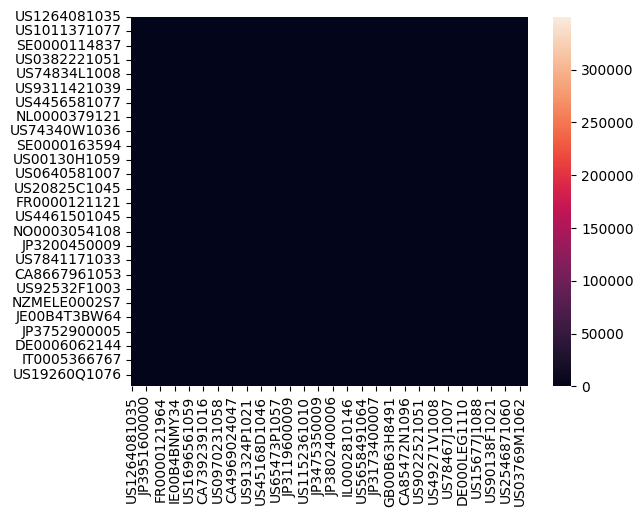

In [ ]:
import seaborn as sns

sns.heatmap(cov_matrix)